In [1]:
import pyro
import torch
import pyro.distributions as dist
from chirho.dynamical.ops import State
from collections import OrderedDict
from typing import (
    Union,
)
import matplotlib.pyplot as plt

import chirho.contrib.compexp as ep  # TODO rename to expectation_programming (?)

pyro.settings.set(module_local_params=True)

PT = torch.nn.Parameter
TT = torch.Tensor
tt = torch.tensor
UPTT = Union[PT, TT]

## Minimizing Costs of Clean Energy Switch While Meeting Peak Load of Power Grid

A small country is planning to switch its power grid to clean energy. The grid will need to meet annual peak load, but the country would also like to minimize costs. Planners must contend with unknown polynomial scaling of cost, as the country's small size will require non-linear investments to squeeze more capacity out of limited power options.

These factors, however, are correlated — a strong economy will induce higher peak loads, but will also increase technological options to increase capacity.

Policy makers have two knobs to turn. The first is the capacity of the new power grid. The second is a direct investment in energy research and subsidies. This has the effect of reducing the effects of poor cost scaling and decreasing peak load needs due to efficiency.

In [2]:
def unmarginalized_model():

    # Latent economic factor in annual billions in GDP.
    # economic_strength = es = pyro.sample(
    #     "es",
    #     # dist.Normal(loc=100., scale=10.)
    #     dist.Delta(tt(100.))
    # )
    es = tt(100.)

    # Annual peak load in gigawatts.
    raw_peak_load = pyro.sample(
        "rpl", dist.Normal(loc=es / 10., scale=0.5))

    # Exponent of cost scaling per capacity.
    raw_cost_scaling = pyro.sample(
        "rcs", dist.Normal(loc=1. + 0.5 * (1. + ((100. - es) / 100.)), scale=0.1))

    return OrderedDict(
        rpl=raw_peak_load,
        rcs=raw_cost_scaling
    )

# marginal_rpl_rcs_samples = tt([list(unmarginalized_model().values()) for _ in range(20000)])
# marginal_rpl_rcs_mean = torch.mean(marginal_rpl_rcs_samples, dim=0)
# marginal_rpl_rcs_cov = torch.cov(marginal_rpl_rcs_samples.T)

In [3]:
# TODO this needs to trace out rpl and rcs.
# def model():
#     rplrcs = pyro.sample("rplrcs", dist.MultivariateNormal(
#         loc=marginal_rpl_rcs_mean, covariance_matrix=marginal_rpl_rcs_cov))
#
#     return OrderedDict(
#         rpl=rplrcs[0],
#         rcs=rplrcs[1]
#     )
model = unmarginalized_model

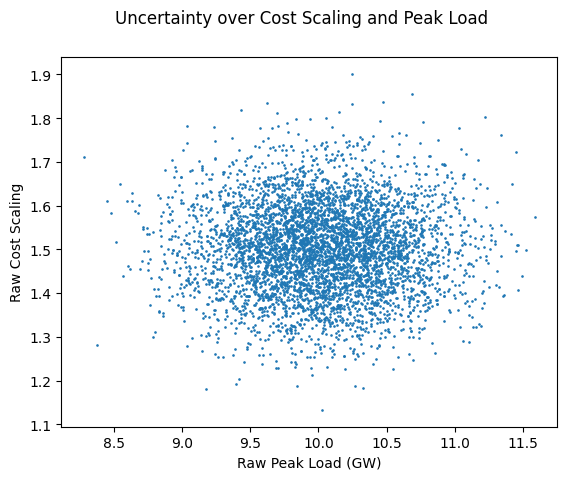

In [4]:
plt.figure()
plt.ylabel("Raw Cost Scaling")
plt.xlabel("Raw Peak Load (GW)")
plt.suptitle("Uncertainty over Cost Scaling and Peak Load")
plt.scatter(*tt([list(model().values()) for _ in range(5000)]).T, s=0.8)
plt.show()

In [5]:
def research_subsidy_outcome(subsidy_opportunity_cost):
    return 1. + torch.log(1. + torch.abs(subsidy_opportunity_cost))/50.

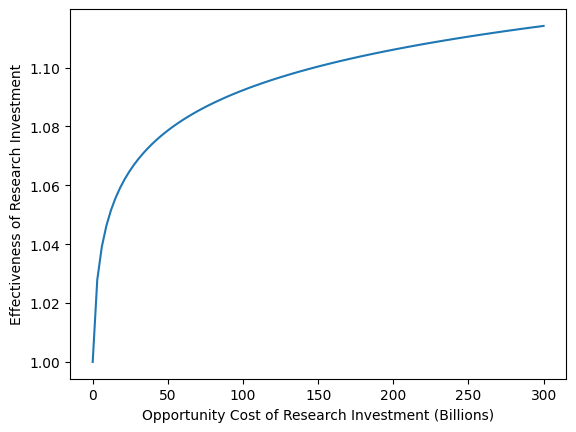

In [6]:
subsidy_val_xx = torch.linspace(0., 300., 100)
plt.ylabel("Effectiveness of Research Investment")
plt.xlabel("Opportunity Cost of Research Investment (Billions)")
plt.plot(subsidy_val_xx, research_subsidy_outcome(subsidy_val_xx))

In [7]:
# Cost in billions to build capacity for a scaled gigawatt.
COST_PER_SCALED_GW = tt(20.)

# Policy parameters: [
#   grid capacity (GW),
#   the opportunity cost (billions) arising from energy research subsidies
# ]
PP_OG = tt([7., 500.])
pp = PT(tt(PP_OG.numpy()))

def cost(plcs):
    adjusted_scaling = plcs["rcs"] / research_subsidy_outcome(pp[1])
    return pp[0] ** adjusted_scaling * COST_PER_SCALED_GW + pp[1]

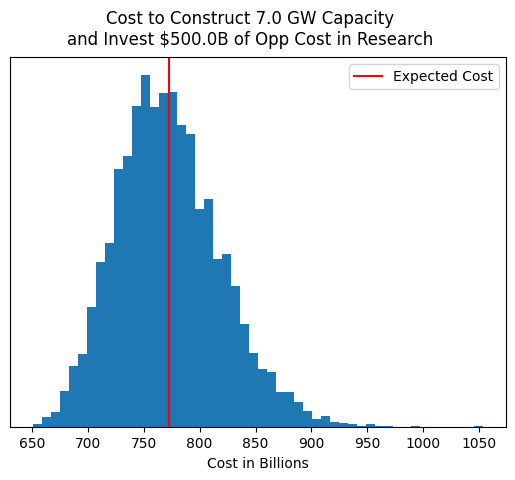

In [8]:
def plot_cost():
    plt.figure()
    plt.suptitle(f"Cost to Construct {pp[0]} GW Capacity\n"
                 f"and Invest ${pp[1]}B of Opp Cost in Research")
    cost_samples = tt([cost(model()).detach() for _ in range(5000)])
    plt.hist(cost_samples, bins=50)
    plt.axvline(x=torch.mean(cost_samples), color='red', label=f"Expected Cost")
    plt.xlabel("Cost in Billions")
    plt.yticks([])
    plt.legend()
    plt.show()
plot_cost()

#### Threshold on Penalized Expected Margin
As a first pass, the country will attempt to minimize costs while keeping the penalized, expected margin over peak load above some threshold.

In [9]:
def penalty(margin_val):
    return 1. - torch.exp(-margin_val)

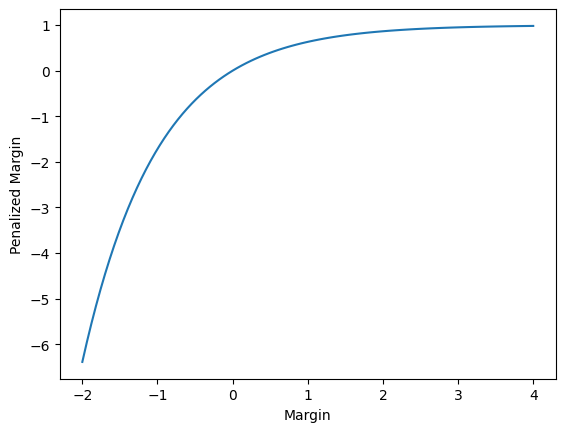

In [10]:
margin_val_xx = torch.linspace(-2., 4., 100)
plt.ylabel("Penalized Margin")
plt.xlabel("Margin")
plt.plot(margin_val_xx, penalty(margin_val_xx))

In [11]:
def margin(dadb):
    return pp[0] - dadb["rpl"] / research_subsidy_outcome(pp[1])

def penalized_margin(dadb):
    # Expected margin of capacity over annual peak load. Energy research also
    #  reduces peak load needs.

    return penalty(margin(dadb))

In [12]:
PENALIZED_MARGIN_THRESH_GW = PMT = tt(0.7)

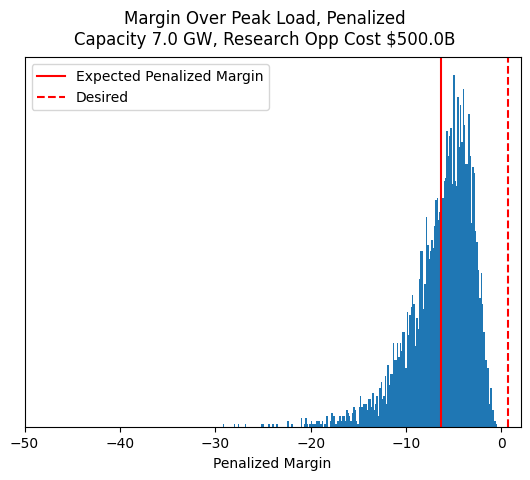

In [13]:
def plot_margin(xlim, n=5000):
    plt.figure()
    plt.suptitle(f"Margin Over Peak Load, Penalized\n"
                 f"Capacity {pp[0]} GW, "
                 f"Research Opp Cost ${pp[1]}B")
    margin_samples = tt([penalized_margin(model()).detach() for _ in range(n)])
    plt.hist(margin_samples, bins=200)
    plt.axvline(x=torch.mean(margin_samples), color='red', label=f"Expected Penalized Margin")
    plt.xlabel("Penalized Margin")
    plt.yticks([])
    plt.axvline(x=PENALIZED_MARGIN_THRESH_GW, color='red', linestyle='dashed', label="Desired")
    plt.legend()
    plt.xlim((xlim, 2.))
    plt.show()
plot_margin(-50.)

In [14]:
# The policy objective is to minimize cost while keeping the expected penalized
#  margin below specified threshold.

tau_pmmdo = ep.C(tt(6e2))

# The deconstrained objective minimizes the cost and the degree
#  to which the expected penalized capacity sits below the
#  desired threshold.
penalized_margin_mean_deconstrained_objective = pmmdo = \
    ep.E(cost, "cost") \
    + tau_pmmdo * (ep.E(lambda s: -penalized_margin(s), "pmarg") + ep.C(PMT)).relu()
    # - tau_pmmdo * ep.E(penalized_margin, "pmarg")

##### Optimization


In [15]:
class DecisionOptimizer:
    def __init__(
            self,
            flat_dparams: PT,
            model: ep.typedecs.ModelType,
            cost: ep.ComposedExpectation,
            expectation_handler: ep.ExpectationHandler,
            lr: float
    ):
        self.flat_dparams = flat_dparams
        self.model = model
        # ep.ComposedExpectation objects can be auto-differentiated.
        self.cost_grad: ep.ComposedExpectation = cost.grad(self.flat_dparams)
        self.expectation_handler = expectation_handler
        self._lr = lr

        self.optim = torch.optim.SGD((self.flat_dparams,), lr=self._lr)

    @property
    def lr(self):
        return self._lr

    @lr.setter
    def lr(self, lr):
        self._lr = lr
        for g in self.optim.param_groups:
            g['lr'] = lr

    def estimate_grad(self):
        self.optim.zero_grad()
        self.flat_dparams.grad = None

        with self.expectation_handler:
            grad_estimate_: TT = self.cost_grad(self.model)

        return grad_estimate_

    def step_grad(self, grad_estimate_):
        self.flat_dparams.grad = grad_estimate_
        self.optim.step()

    def step(self):
        grad_estimate = self.estimate_grad()
        self.step_grad(grad_estimate)

def norm_to_clip(grad_estimate_, clip):
    mag = torch.norm(grad_estimate_)
    return torch.where(mag > clip, (grad_estimate_ / mag) * clip, grad_estimate_)

In [16]:
pmmdo_opt = DecisionOptimizer(
    flat_dparams=pp,
    model=model,
    cost=penalized_margin_mean_deconstrained_objective,
    expectation_handler=ep.MonteCarloExpectationHandler(num_samples=1),
    lr=9e-3
)

capacity_param_pmmdo = []
research_param_pmmdo = []

In [17]:
N = 25000
for i in range(N):
    grad_estimate = pmmdo_opt.estimate_grad()
    grad_estimate[1] *= 1e1
    grad_estimate[0] *= 2e-4
    pmmdo_opt.step_grad(grad_estimate)

    capacity_param_pmmdo.append(pp[0].item())
    research_param_pmmdo.append(pp[1].item())

In [18]:
def plot_parameter_optimization(capacity_param, research_param):

    fig, axs = plt.subplots(2, 1, sharex=True)

    axs[0].plot(capacity_param)
    axs[0].set_title("Capacity to Build")
    axs[1].plot(research_param)
    axs[1].set_title("Opp Cost of Research")

    plt.figure()
    plt.plot(capacity_param, research_param)
    plt.xlabel("Capacity to Build")
    plt.ylabel("Opp Cost of Research")

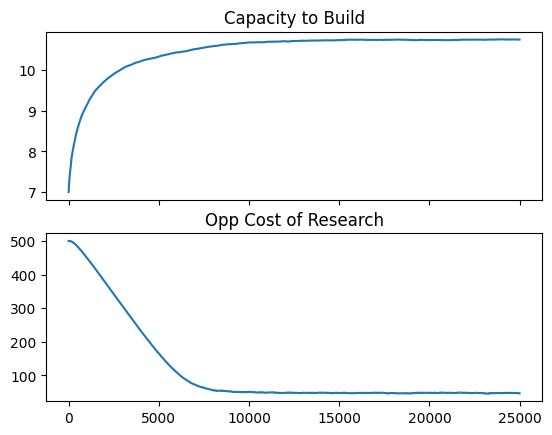

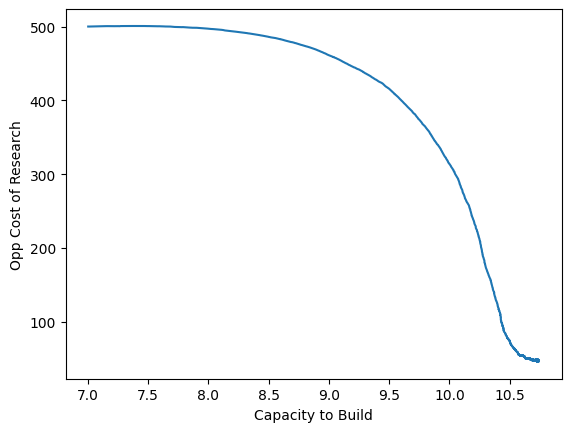

In [19]:
plot_parameter_optimization(capacity_param_pmmdo, research_param_pmmdo)

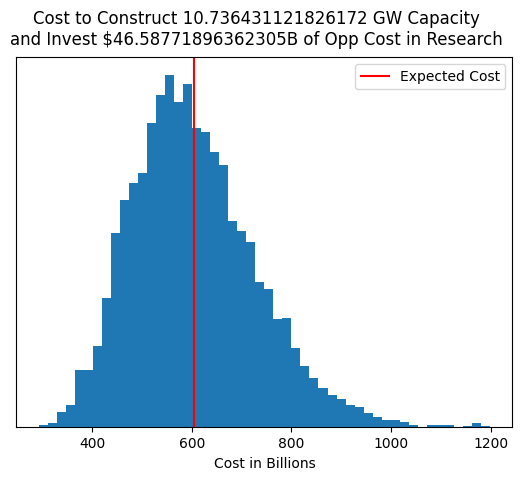

In [20]:
plot_cost()

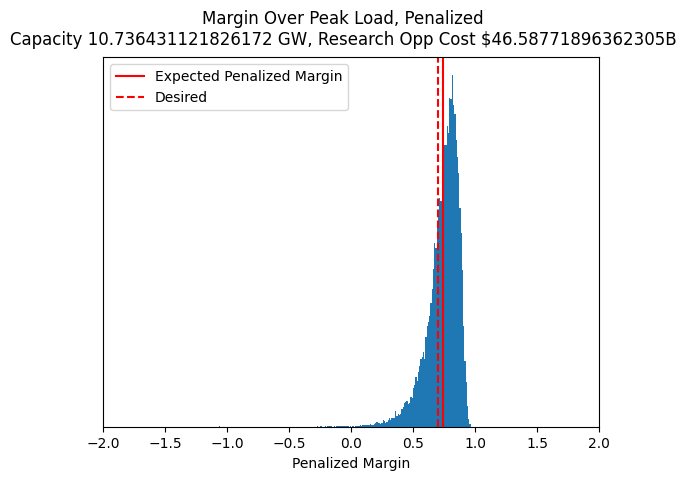

In [21]:
plot_margin(-2., n=25000)

This looks largely decent, but lets zoom in to get a sense of variance in these estimates. This isn't terrible, but let's see if we can do better.

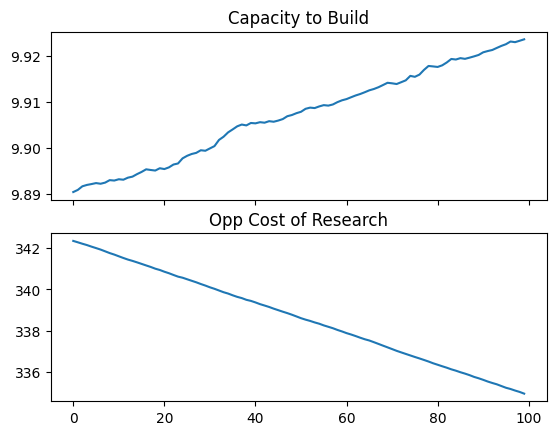

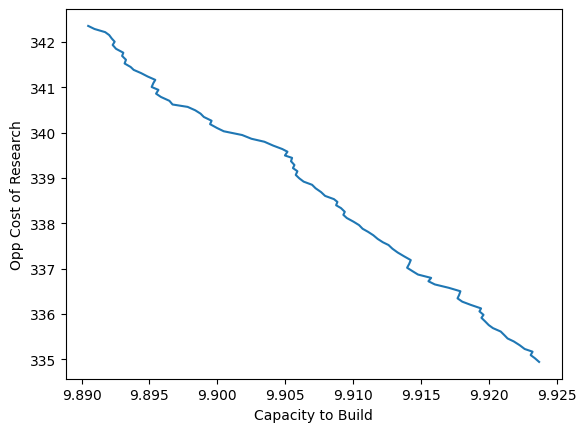

In [22]:
SLC_START = 2500
SLC_END = SLC_START + 100
plot_parameter_optimization(capacity_param_pmmdo[SLC_START:SLC_END], research_param_pmmdo[SLC_START:SLC_END])

#### Estimating Gradients with TABI


In [23]:
# Reset the parameters.
pp.data = PP_OG.data

capacity_param_tabi_warm = []
research_param_tabi_warm = []

In [24]:
N = SLC_START
for i in range(N):
    grad_estimate = pmmdo_opt.estimate_grad()
    grad_estimate[1] *= 1e1
    grad_estimate[0] *= 2e-4
    pmmdo_opt.step_grad(grad_estimate)

    capacity_param_tabi_warm.append(pp[0].item())
    research_param_tabi_warm.append(pp[1].item())

In [25]:
# Take the gradient of the objective, but this time split atoms according to the tabi
#  decomposition.
pmmdo_tabi_grad = penalized_margin_mean_deconstrained_objective.grad(params=pp, split_atoms=True)

In [26]:
[p for p in pmmdo_tabi_grad.parts]

[dcost_dp0_split_pos,
 dcost_dp0_split_neg,
 dcost_dp0_split_den,
 dcost_dp1_split_pos,
 dcost_dp1_split_neg,
 dcost_dp1_split_den,
 drelu(pmarg + 0.699999988079071)_dp0_split_pos,
 drelu(pmarg + 0.699999988079071)_dp0_split_neg,
 drelu(pmarg + 0.699999988079071)_dp0_split_den,
 drelu(pmarg + 0.699999988079071)_dp1_split_pos,
 drelu(pmarg + 0.699999988079071)_dp1_split_neg,
 drelu(pmarg + 0.699999988079071)_dp1_split_den]

In [27]:
# The optimal denominating guides are actually all just the prior, since we aren't conditioning
#  on data here, and because the intervention does
#  not affect the distribution over latent parameters. Thus, we can swap all denominating guide
#  out for the prior.
for p in pmmdo_tabi_grad.parts:
    if "den" in p.name:
        p.guide = model

In [28]:
# TABI estimation comprises the TABI decomposition and standard importance sampling.
pmmdo_iseh_tabi = ep.ImportanceSamplingExpectationHandler(num_samples=1)

pmmdo_iseh_tabi.register_guides(
    ce=pmmdo_tabi_grad,
    model=model,
    # auto_guide=pyro.infer.autoguide.AutoIAFNormal,
    # auto_guide_kwargs=dict(num_transforms=3)
    auto_guide=pyro.infer.autoguide.AutoMultivariateNormal,
    auto_guide_kwargs=dict(init_scale=1.0)
)

# [f"{k}: {v}" for k, v in pmmdo_iseh_tabi.guides.items()]

In [51]:
import re

def visualize_iseh_guides(iseh_: ep.ImportanceSamplingExpectationHandler, keys=None):
    if keys is None:
        keys = sorted(iseh_.keys())

    fig, axs = plt.subplots(len(keys) // 3, 3, figsize=(3*4, len(keys) // 3*4), sharex=True, sharey=True)

    ii = 0
    for ax, key in zip(axs.flatten(), keys):
        print("Visualizing ", key)
        iseh_.plot_guide_pseudo_likelihood_2d(
            rv1_name='rpl',
            rv2_name='rcs',
            ax=ax,
            key=key,
            n=2000,
            resolution=25,
            guide_scatter_kwargs=dict(color='blue', alpha=0.1, s=0.5),
            model_contour_kwargs=dict(colors='orange', levels=6, linewidths=0.8)
        )
        ax.set_title(re.sub(r'\d+\.\d+', '#', key))
        ii += 1

In [48]:
pmmdo_iseh_tabi.num_samples = 100
for part in pmmdo_tabi_grad.parts:
    if 'den' in part.name:
        continue
    with pmmdo_iseh_tabi:
        print(part.name, part(pmmdo_iseh_tabi.registered_model))
pmmdo_iseh_tabi.num_samples = 1

dcost_dp0_split_pos tensor(70.2651, grad_fn=<MeanBackward1>)
dcost_dp0_split_neg tensor(1.0146e-25, grad_fn=<MeanBackward1>)
dcost_dp1_split_pos tensor(0.2908, grad_fn=<MeanBackward1>)
dcost_dp1_split_neg tensor(0.0149, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp0_split_pos tensor(1.0213e-25, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp0_split_neg tensor(0.0969, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp1_split_pos tensor(9.7723e-26, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp1_split_neg tensor(0.0005, grad_fn=<MeanBackward1>)


In [31]:
N_pmmdo_iseh_tabi = 3000
with ep.FillReluAtLevelExp(beta=tt(0.05)):
    losses1 = pmmdo_iseh_tabi.optimize_guides(
        lr=1e-2,
        n_steps=N_pmmdo_iseh_tabi,
        adjust_grads_=None,
        callback=None,
        keys=[p.name for p in pmmdo_tabi_grad.parts if ("den" not in p.name) and ("dcost_dp0_split" not in p.name)]
    )

with ep.FillReluAtLevelExp(beta=tt(5.)):
    losses2 = pmmdo_iseh_tabi.optimize_guides(
        lr=1e-2,
        n_steps=N_pmmdo_iseh_tabi,
        adjust_grads_=None,
        callback=None,
        keys=[p.name for p in pmmdo_tabi_grad.parts if ("den" not in p.name) and ("dcost_dp0_split" in p.name)]
    )

In [32]:
losses = {**losses1, **losses2}

In [ ]:
# DEBUG
DEBUG_KEYS = [p.name for p in pmmdo_tabi_grad.parts if "cost_dp1" in p.name]

In [62]:
# DEBUG
for k in [k for k in DEBUG_KEYS if "den" not in k]:
    pmmdo_iseh_tabi.guides[k] = pyro.infer.autoguide.AutoIAFNormal(pmmdo_iseh_tabi.registered_model, num_transforms=3)

Visualizing  dcost_dp1_split_pos
Visualizing  dcost_dp1_split_neg
Visualizing  dcost_dp1_split_den


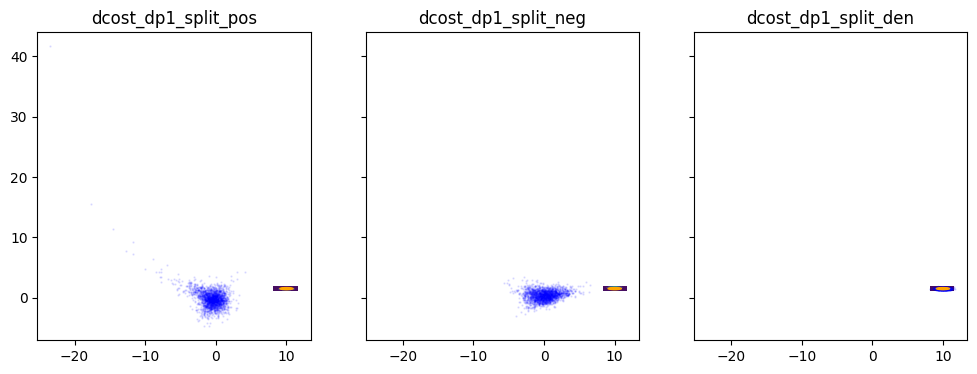

In [63]:
# DEBUG
visualize_iseh_guides(pmmdo_iseh_tabi, keys=DEBUG_KEYS)

In [64]:
# DEBUG
with ep.FillReluAtLevelExp(beta=tt(0.05)):
    visualize_iseh_guides(pmmdo_iseh_tabi, keys=DEBUG_KEYS)
    losses = pmmdo_iseh_tabi.optimize_guides(
        lr=1e-3,
        n_steps=10000,
        adjust_grads_=None,
        callback=None,
        keys=[k for k in DEBUG_KEYS if "den" not in k]
    )

Visualizing  dcost_dp1_split_pos
Visualizing  dcost_dp1_split_neg
Visualizing  dcost_dp1_split_den


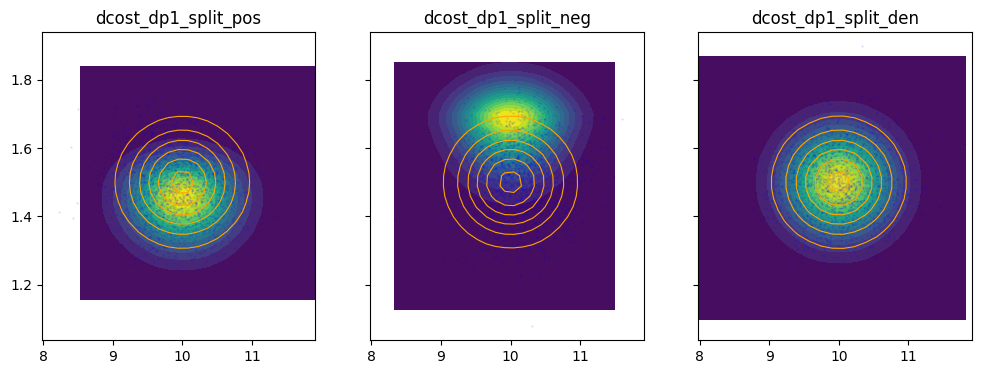

In [67]:
# DEBUG
with ep.FillReluAtLevelExp(beta=tt(0.05)):
    visualize_iseh_guides(pmmdo_iseh_tabi, keys=DEBUG_KEYS)

Visualizing  dcost_dp1_split_pos
Visualizing  dcost_dp1_split_neg
Visualizing  dcost_dp1_split_den


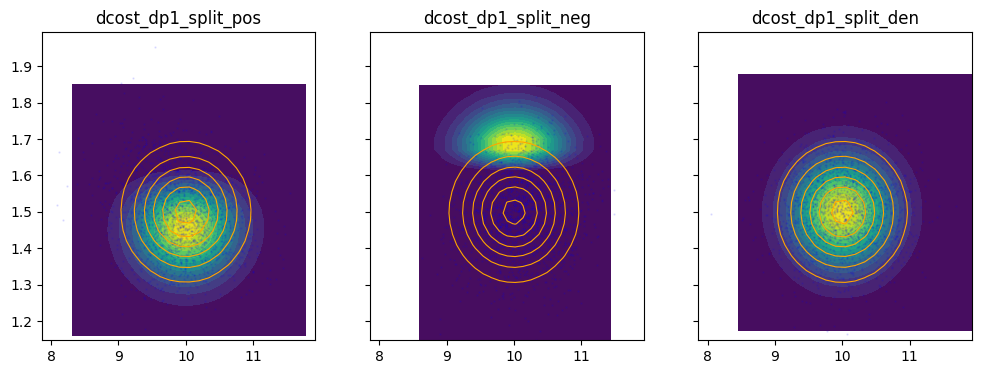

In [65]:
# DEBUG
visualize_iseh_guides(pmmdo_iseh_tabi, keys=DEBUG_KEYS)

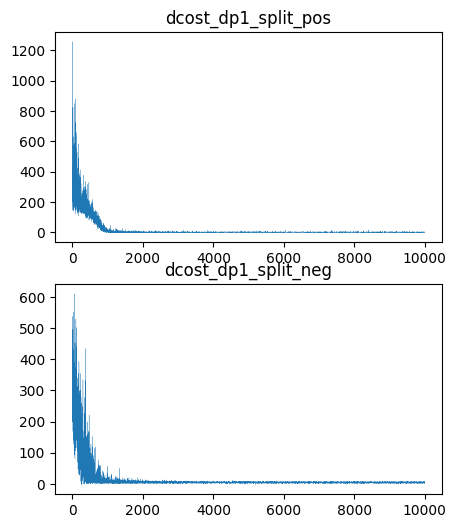

In [66]:
fig, axs = plt.subplots(nrows=len(losses), ncols=1, figsize=(5, 3 * len(losses)))
for ax, (k, vv) in zip(axs, losses.items()):
    ax.set_title(re.sub(r'\d+\.\d+', '#', k))
    ax.plot([v.detach() for v in vv[:]], linewidth=0.2)

In [35]:
# Reset the parameters.
pp.data = PP_OG.data

capacity_param_tabi = []
research_param_tabi = []

In [36]:
pmmdo_opt.cost_grad = pmmdo_tabi_grad
pmmdo_opt.expectation_handler = pmmdo_iseh_tabi

In [37]:
N = 25000
srelu_beta_scale = 1e-1
tabi_guide_n_steps = 250
for i in range(N):
    grad_estimate = pmmdo_opt.estimate_grad()
    grad_estimate[1] *= 1e1
    grad_estimate[0] *= 2e-4
    pmmdo_opt.step_grad(grad_estimate)

    if i % 50 == 0:
        with ep.FillReluAtLevelExp(beta=tt(0.05 * srelu_beta_scale)):
            pmmdo_iseh_tabi.optimize_guides(
                lr=1e-2,
                n_steps=tabi_guide_n_steps,
                adjust_grads_=None,
                callback=None,
                keys=[p.name for p in pmmdo_tabi_grad.parts if ("den" not in p.name) and ("dcost_dp0_split" not in p.name)]
            )

        with ep.FillReluAtLevelExp(beta=tt(5. * srelu_beta_scale)):
            pmmdo_iseh_tabi.optimize_guides(
                lr=1e-2,
                n_steps=tabi_guide_n_steps,
                adjust_grads_=None,
                callback=None,
                keys=[p.name for p in pmmdo_tabi_grad.parts if ("den" not in p.name) and ("dcost_dp0_split" in p.name)]
            )

    capacity_param_tabi.append(pp[0].item())
    research_param_tabi.append(pp[1].item())

    print(f"Iteration {i}/{N}", end="\r")

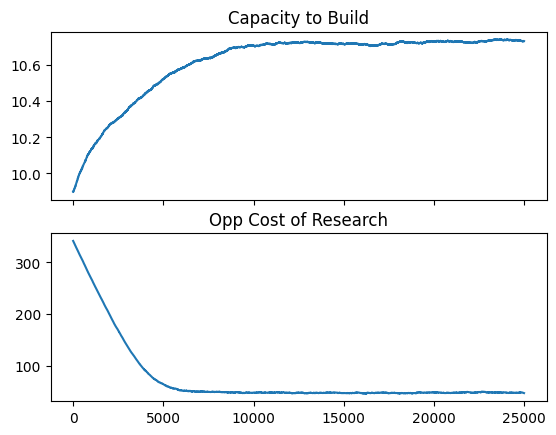

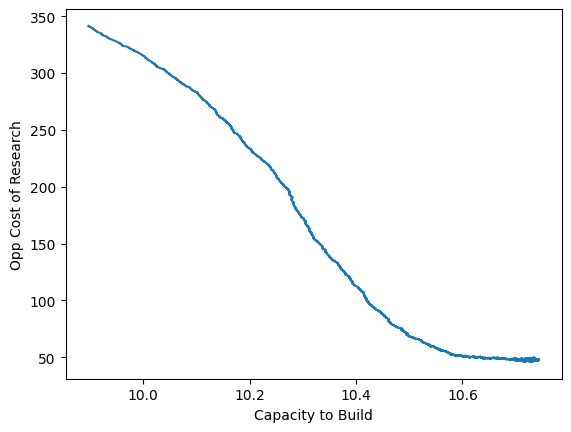

In [38]:
plot_parameter_optimization(capacity_param_tabi, research_param_tabi)

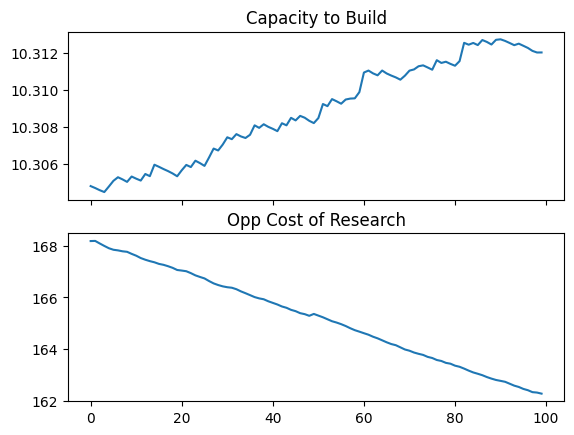

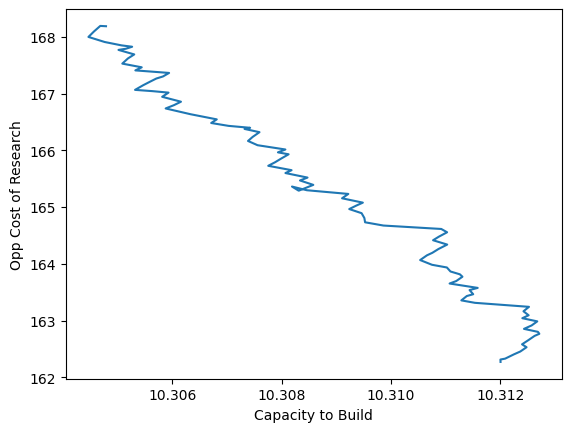

In [46]:
SLC_START = 2500
SLC_END = SLC_START + 100
plot_parameter_optimization(capacity_param_tabi[SLC_START:SLC_END], research_param_tabi[SLC_START:SLC_END])

Visualizing  dcost_dp0_split_den
Visualizing  dcost_dp0_split_neg
Visualizing  dcost_dp0_split_pos
Visualizing  dcost_dp1_split_den
Visualizing  dcost_dp1_split_neg
Visualizing  dcost_dp1_split_pos
Visualizing  drelu(pmarg + 0.699999988079071)_dp0_split_den
Visualizing  drelu(pmarg + 0.699999988079071)_dp0_split_neg
Visualizing  drelu(pmarg + 0.699999988079071)_dp0_split_pos
Visualizing  drelu(pmarg + 0.699999988079071)_dp1_split_den
Visualizing  drelu(pmarg + 0.699999988079071)_dp1_split_neg
Visualizing  drelu(pmarg + 0.699999988079071)_dp1_split_pos


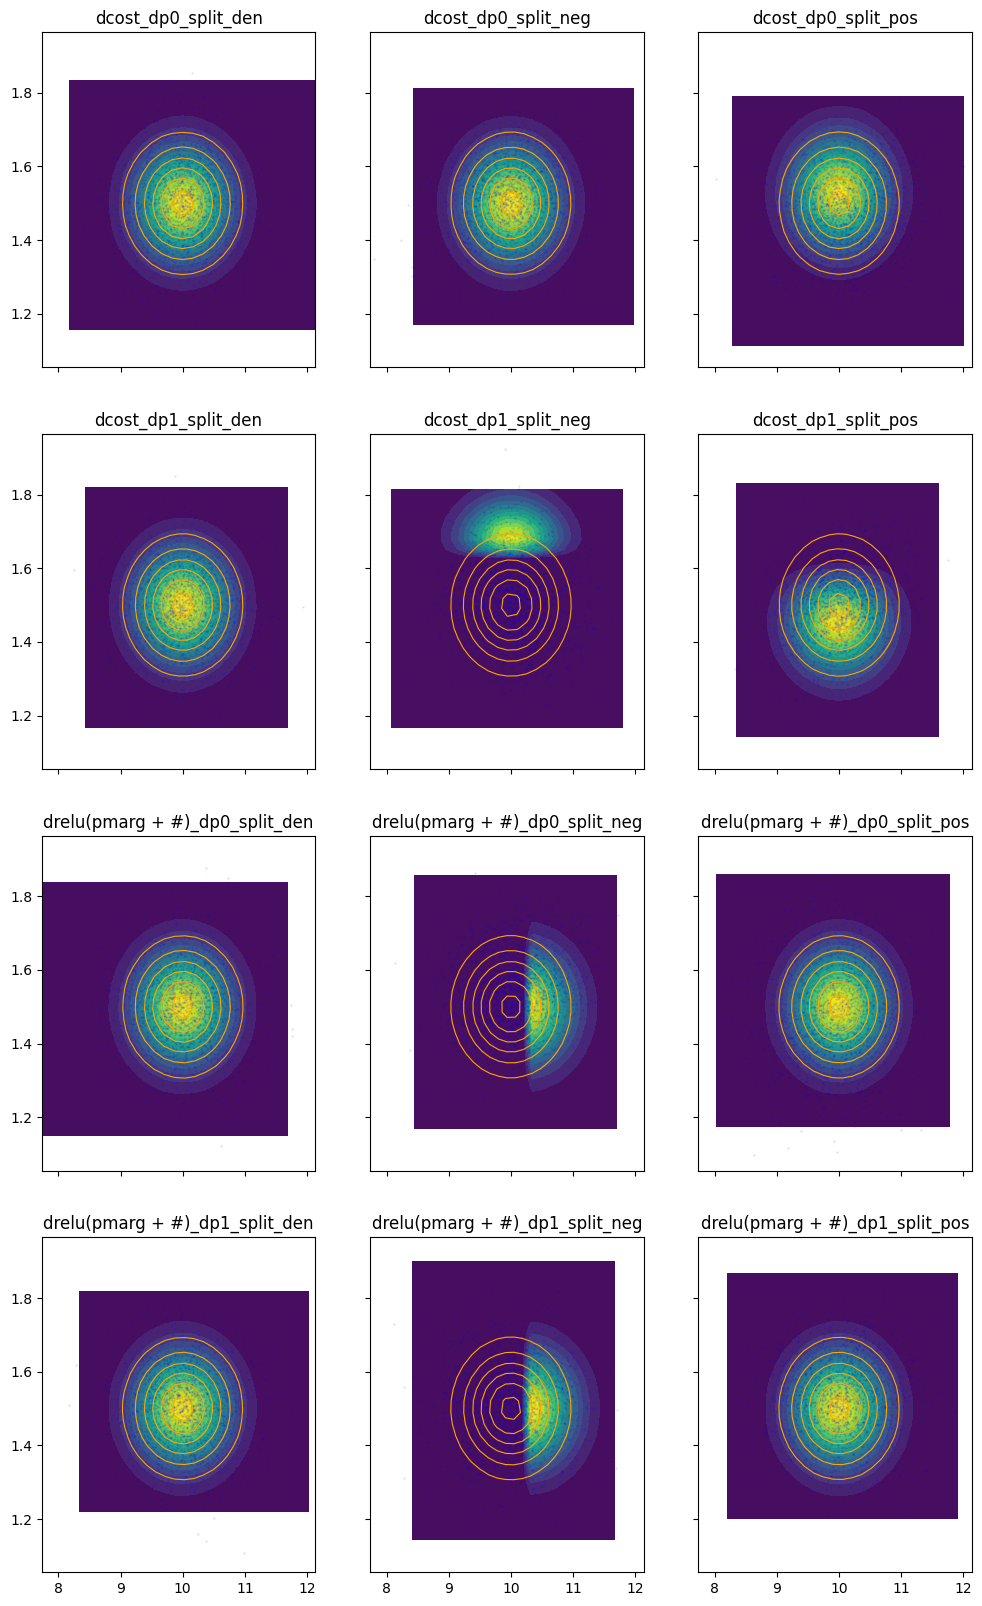

In [40]:
visualize_iseh_guides(pmmdo_iseh_tabi)

Visualizing  dcost_dp0_split_den
Visualizing  dcost_dp0_split_neg
Visualizing  dcost_dp0_split_pos
Visualizing  dcost_dp1_split_den
Visualizing  dcost_dp1_split_neg
Visualizing  dcost_dp1_split_pos
Visualizing  drelu(pmarg + 0.699999988079071)_dp0_split_den
Visualizing  drelu(pmarg + 0.699999988079071)_dp0_split_neg
Visualizing  drelu(pmarg + 0.699999988079071)_dp0_split_pos
Visualizing  drelu(pmarg + 0.699999988079071)_dp1_split_den
Visualizing  drelu(pmarg + 0.699999988079071)_dp1_split_neg
Visualizing  drelu(pmarg + 0.699999988079071)_dp1_split_pos


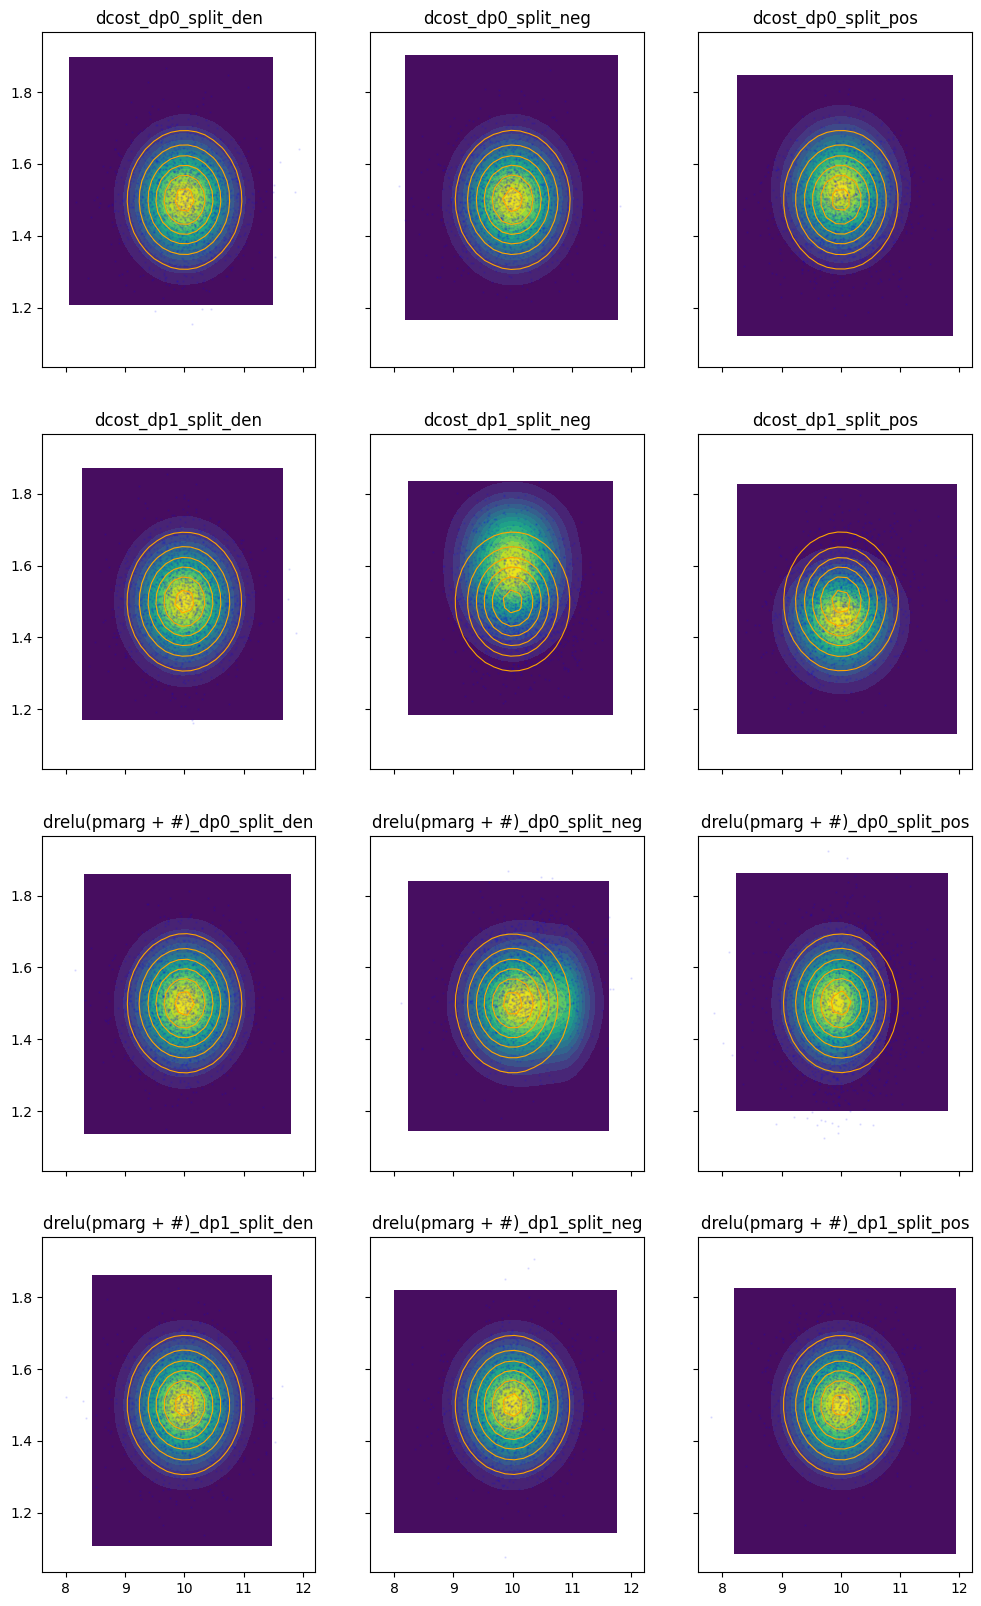

In [41]:
with ep.FillReluAtLevelExp(beta=tt(0.1)):
    visualize_iseh_guides(pmmdo_iseh_tabi)

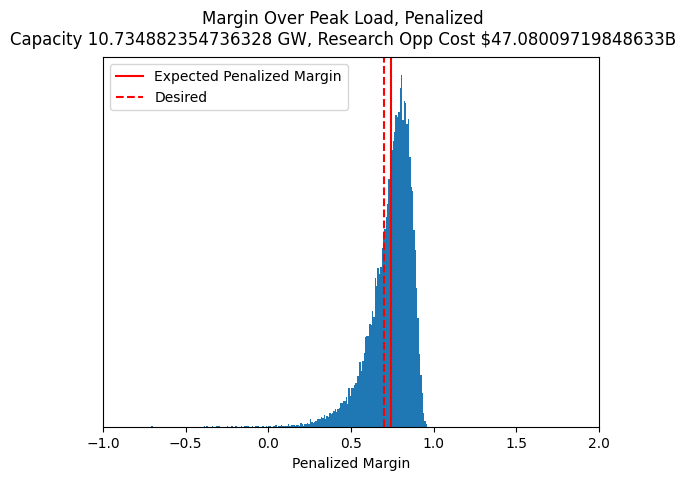

In [44]:
plot_margin(-1, 25000)

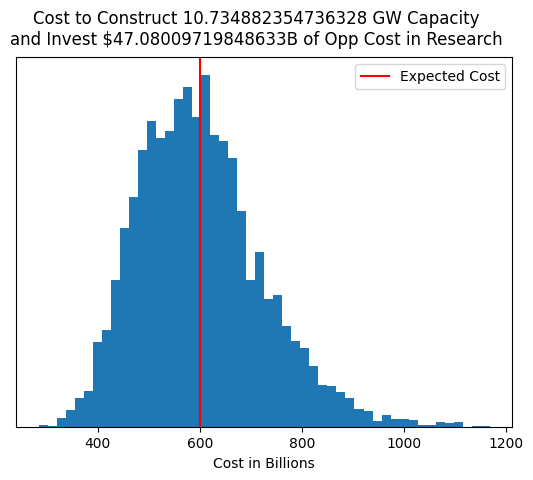

In [43]:
plot_cost()

In [45]:
pmmdo_iseh_tabi.num_samples = 100
for part in pmmdo_tabi_grad.parts:
    if 'den' in part.name:
        continue
    with pmmdo_iseh_tabi:
        print(part.name, part(pmmdo_iseh_tabi.registered_model))
pmmdo_iseh_tabi.num_samples = 1

dcost_dp0_split_pos tensor(73.4341, grad_fn=<MeanBackward1>)
dcost_dp0_split_neg tensor(9.7925e-26, grad_fn=<MeanBackward1>)
dcost_dp1_split_pos tensor(0.3225, grad_fn=<MeanBackward1>)
dcost_dp1_split_neg tensor(0.0215, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp0_split_pos tensor(9.5587e-26, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp0_split_neg tensor(0.1277, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp1_split_pos tensor(1.0407e-25, grad_fn=<MeanBackward1>)
drelu(pmarg + 0.699999988079071)_dp1_split_neg tensor(0.0005, grad_fn=<MeanBackward1>)
